In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table

In [3]:
import astropy.io.fits as fits

In [4]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Using Theano backend.


In [5]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [6]:
from matplotlib.colors import LogNorm

First we load the quasar values from the file uploaded by Andreu

In [7]:
def load_weights():

    table = astropy.table.Table.read('./Downloads/quasarvalue.txt', format='ascii')
    z_col, r_col, w_col = table.columns[0], table.columns[1], table.columns[2]

    z_vec = np.unique(z_col)
    z_edges = np.linspace(2.025, 4.025, len(z_vec) + 1)
    assert np.allclose(z_vec, 0.5 * (z_edges[1:] + z_edges[:-1]))

    r_vec = np.unique(r_col)
    r_edges = np.linspace(18.05, 23.05, len(r_vec) + 1)
    assert np.allclose(r_vec, 0.5 * (r_edges[1:] + r_edges[:-1]))
    
    W = np.empty((len(r_vec), len(z_vec)))
    k = 0
    for j in range(len(z_vec)):
        for i in range(len(r_vec))[::-1]:
            assert r_col[k] == r_vec[i]
            assert z_col[k] == z_vec[j]
            W[i, j] = w_col[k]
            k += 1
    return W, r_edges, r_vec, z_edges, z_vec
    
W, r_edges, r_vec, z_edges, z_vec = load_weights()

We now load the truth table and use the first 1000 as test

In [8]:
truth_table = astropy.table.Table.read('./fake_qso/truth_tab_all_0.0.3_z_mag.fits.gz')

In [9]:
truth_table = truth_table[1000:]

In [10]:
hzqso = truth_table['TRUE_OBJTYPE']=='HZQSO'
bin1 = np.logical_and(truth_table['Z']>=2.1,truth_table['Z']<2.6)
bin2 = np.logical_and(truth_table['Z']>=2.6,truth_table['Z']<3.1)
bin3 = truth_table['Z']>=3.1
hzqso_1 = np.logical_and(hzqso,bin1)
hzqso_2 = np.logical_and(hzqso,bin2)
hzqso_3 = np.logical_and(hzqso,bin3)
print np.count_nonzero(hzqso_1),np.count_nonzero(hzqso_2),np.count_nonzero(hzqso_3)
truth_table['TRUE_OBJTYPE'][hzqso_1]='HZ_QSO_1'
truth_table['TRUE_OBJTYPE'][hzqso_2]='HZ_QSO_2'
truth_table['TRUE_OBJTYPE'][hzqso_3]='HZ_QSO_3'
elgs = truth_table['TRUE_OBJTYPE']=='ELG'
truth_table['TRUE_OBJTYPE'][elgs]='GALAXY'
encoder = LabelEncoder()
encoder.fit(truth_table['TRUE_OBJTYPE'])
encoded_Y = encoder.transform(truth_table['TRUE_OBJTYPE'])
dummy_y = np_utils.to_categorical(encoded_Y)

235 259 202


In [11]:
truth_table

TARGETID,TRUE_OBJTYPE,Z,MAG [5]
int64,str10,float64,float32
1742919962404063486,HZ_QSO_1,2.40391421318,0.0 .. 0.0
1272794898351801880,GALAXY,0.0,0.0 .. 0.0
296298001618411963,HZ_QSO_2,2.82878661156,0.0 .. 0.0
4521065280074375992,GALAXY,0.0,0.0 .. 0.0
4169372136117380197,QSO,1.42629230022,0.0 .. 0.0
1047587775324412495,QSO,0.654396533966,0.0 .. 0.0
1442848234505557772,QSO,1.01997351646,0.0 .. 0.0
2637117540303182543,STAR,0.0,0.0 .. 0.0
2321810279545132932,HZ_QSO_1,2.31568050385,0.0 .. 0.0


We load the output from the classifier

In [12]:
prob_table = astropy.table.Table.read('./fake_qso/quassifier_results_dense_prob_03032017.fits.gz')

And the output from RM

In [65]:
tab_nico = astropy.table.Table.read('./fake_qso/rm_brick_osu_0.0.3.fits')

In [66]:
tab_nico=tab_nico[1000:]

In [13]:
prob_table = prob_table[1000:]

In [14]:
prob_table

TARGETID,MAG [5],Prob [6]
int64,float32,float32
1742919962404063486,0.0 .. 0.0,2.77344e-18 .. 1.04631e-08
1272794898351801880,0.0 .. 0.0,0.43693 .. 7.97182e-11
296298001618411963,0.0 .. 0.0,1.90092e-13 .. 1.24587e-08
4521065280074375992,0.0 .. 0.0,0.365885 .. 6.34262e-07
4169372136117380197,0.0 .. 0.0,4.20555e-17 .. 3.74645e-15
1047587775324412495,0.0 .. 0.0,3.28295e-18 .. 1.21542e-17
1442848234505557772,0.0 .. 0.0,2.04253e-11 .. 9.86263e-12
2637117540303182543,0.0 .. 0.0,3.40919e-07 .. 0.517718
2321810279545132932,0.0 .. 0.0,1.89857e-16 .. 0.000320208


We take the probabilities and convert to a category

In [15]:
result_y = np_utils.categorical_probas_to_classes(prob_table['Prob'])

In [16]:
classes_y = encoder.inverse_transform(result_y)

In [17]:
labels = ['GALAXY','QSO BIN-1','QSO BIN-2','QSO BIN-3', 'QSO TRACER', 'STAR']

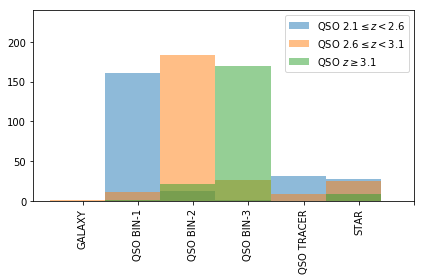

In [20]:
counts, bins, patches = plt.hist(result_y[hzqso_1],alpha=0.5,label='QSO $2.1 \leq z < 2.6$', bins=6, range=(0,5))
plt.hist(result_y[hzqso_2],alpha=0.5,label='QSO $2.6 \leq z < 3.1$', bins=6, range=(0,5))
plt.hist(result_y[hzqso_3],alpha=0.5,label='QSO $z \geq 3.1$',bins=6,range=(0,5))
plt.legend(loc='best')
plt.xticks(bins,labels,rotation='vertical')
ax = plt.gca()
ax.set_xticks(bins+0.5)
plt.ylim(0,240)
savefig('./fake_qso/qso_classified_as.png')

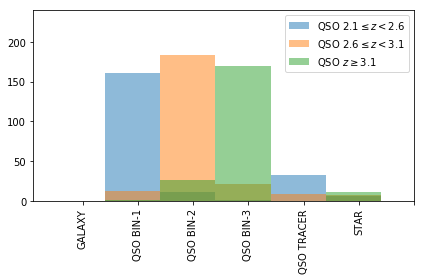

In [22]:
hzqso_d_1 = classes_y == 'HZ_QSO_1'
hzqso_d_2 = classes_y == 'HZ_QSO_2'
hzqso_d_3 = classes_y == 'HZ_QSO_3'
counts, bins, patches = plt.hist(encoded_Y[hzqso_d_1],alpha=0.5,label='QSO $2.1 \leq z < 2.6$', bins=6, range=(0,5))
plt.hist(encoded_Y[hzqso_d_2],alpha=0.5,label='QSO $2.6 \leq z < 3.1$', bins=6, range=(0,5))
plt.hist(encoded_Y[hzqso_d_3],alpha=0.5,label='QSO $z \geq 3.1$',bins=6,range=(0,5))
plt.legend(loc='best')
plt.xticks(bins,labels,rotation='vertical')
ax = plt.gca()
ax.set_xticks(bins+0.5)
plt.ylim(0,240)
savefig('./fake_qso/true_classified_qso.png')

Now we will use the probabilities to weight each class instead of just using the class with the maximum probability, i.e., we stack the pdfs of each object.

In [23]:
wgt = np.array([prob_table['Prob'][i,encoded_Y[i]]/np.sum(prob_table['Prob'][i,:]) for i in range(0,len(prob_table))])

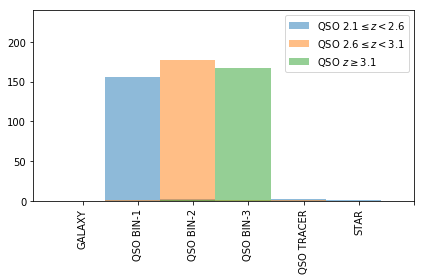

In [26]:
counts, bins, patches = plt.hist(encoded_Y[hzqso_d_1],alpha=0.5,label='QSO $2.1 \leq z < 2.6$', bins=6, range=(0,5),weights=wgt[hzqso_d_1])
plt.hist(encoded_Y[hzqso_d_2],alpha=0.5,label='QSO $2.6 \leq z < 3.1$', bins=6, range=(0,5),weights=wgt[hzqso_d_2])
plt.hist(encoded_Y[hzqso_d_3],alpha=0.5,label='QSO $z \geq 3.1$',bins=6,range=(0,5),weights=wgt[hzqso_d_3])
plt.legend(loc='best')
plt.xticks(bins,labels,rotation='vertical')
ax = plt.gca()
ax.set_xticks(bins+0.5)
plt.ylim(0,240)
savefig('./fake_qso/true_classified_qso_weighted.png')

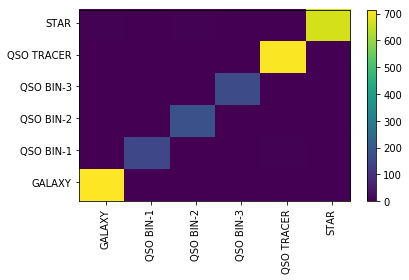

In [27]:
plt.hist2d(encoded_Y,result_y,weights=wgt, bins=6,range=[(0,5),(0,5)], cmap='viridis')
plt.xticks(bins,labels,rotation='vertical')
plt.yticks(bins,labels,rotation='horizontal')
ax = plt.gca()
ax.set_xticks(bins+0.5)
ax.set_yticks(bins+0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.colorbar()
plt.savefig('./fake_qso/class_matrix.png')

Let's take a look to the QSO values

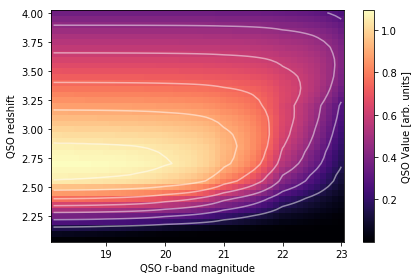

In [28]:
def plot_weights(W=W):
    plt.pcolormesh(r_edges, z_edges, W.T, cmap='magma')
    plt.colorbar().set_label('QSO Value [arb. units]')
    plt.contour(r_vec, z_vec, W.T, colors='w', alpha=0.5)
    plt.xlabel('QSO r-band magnitude')
    plt.ylabel('QSO redshift')

plot_weights()
savefig('qso_values.png')

We use the luminosity function from Ross et al.

In [29]:
#Updated table in r-band from Nathalie.
tabrROSS4= np.array([15.75,66,18,6,5,7,9,8,5,3,2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
16.25,127,57,20,18,23,30,29,19,11,8,5,3,4,4,4,3,2,2,2,1,0,0,0,0,0,0,0,0,0,0,
16.75,226,173,68,61,79,103,99,66,40,27,17,11,12,12,11,10,8,9,10,7,3,1,0,0,1,0,0,0,0,0,
17.25,363,457,221,203,263,342,333,224,139,94,60,36,39,36,32,27,20,21,22,17,11,7,2,0,3,2,1,0,0,0,
17.75,526,998,643,627,810,1055,1045,723,465,321,206,124,125,108,90,71,49,47,46,33,21,14,7,4,6,4,2,1,1,0,
18.25,706,1780,1568,1682,2162,2810,2864,2094,1441,1029,683,412,385,313,245,181,118,104,94,62,39,23,12,8,9,6,3,2,1,0,
18.75,911,2684,3085,3685,4714,6040,6352,5052,3840,2912,2048,1282,1108,848,626,441,274,220,183,115,67,38,20,12,12,7,4,2,1,1,
19.25,1153,3654,4992,6494,8315,10432,11236,9783,8265,6776,5168,3481,2794,2042,1447,981,592,435,336,202,114,62,31,18,17,10,5,3,1,1,
19.75,1448,4735,7070,9655,12424,15345,16759,15608,14240,12548,10424,7651,5864,4188,2903,1933,1157,790,576,336,184,97,46,25,23,13,7,3,2,1,
20.25,1811,6015,9337,13036,16832,20625,22685,21912,20832,19231,17018,13364,10129,7237,5008,3331,2012,1312,916,528,285,148,69,36,32,17,8,4,2,1,
20.75,2257,7582,11965,16858,21789,26601,29364,28848,27951,26390,24146,19717,15045,10881,7607,5111,3142,2001,1362,784,423,217,100,51,43,23,11,5,2,1,
21.25,2799,9531,15159,21438,27696,33745,37335,36983,36173,34474,31993,26624,20484,14992,10610,7219,4519,2849,1916,1109,601,308,141,72,58,30,14,6,3,1,
21.75,3447,11968,19124,27097,34967,42544,47155,46950,46203,44210,41260,34647,26789,19759,14114,9704,6162,3866,2588,1512,827,426,196,98,77,40,18,8,3,1,
22.25,4199,15021,24094,34179,44040,53516,59419,59408,58764,56351,52713,44486,34471,25534,18353,12714,8149,5086,3402,2005,1108,575,266,133,103,52,23,10,4,2,
22.75,5023,18851,30342,43084,55423,67264,74816,75104,74667,71713,67164,56878,44101,32743,23633,16457,10608,6567,4393,2610,1455,761,357,179,135,68,30,13,5,2,
23.25,5828,23656,38207,54302,69731,84522,94186,94941,94887,91265,85543,72660,56330,41877,30321,21194,13703,8393,5614,3356,1886,994,471,237,177,88,38,16,6,2,
23.75,6398,29684,48114,68447,87731,106199,118571,120048,120646,116217,109003,92853,71948,53533,38864,27250,17647,10664,7129,4280,2419,1283,615,311,230,115,49,20,7,2,
24.25,6238,37246,60596,86287,110383,133435,149283,151847,153502,148106,138997,118749,91950,68459,49827,35033,22705,13510,9021,5433,3084,1643,796,405,267,0,56,22,8,3,
24.75,6238,37246,60596,86287,110383,133435,149283,151847,153502,148106,138997,118749,91950,68459,49827,35033,22705,13510,9021,5433,3084,1643,796,405,267,0,56,22,8,3
  ]).reshape(19, 31)


In [30]:
def luminosity_function(data, z_max=6.0, area_sq_deg=10000.):
    """Transform a data array from Nathalie into a tuple gbin, zbin, nqso.
    """
    nr, nz = data.shape
    # r-band magnitude bin centers are in the first column.
    rbin = data[:, 0]
    nz = nz - 1
    # Check that r-band bins are equally spaced.
    assert np.allclose(np.diff(rbin),  rbin[1] - rbin[0])
    # redshift bins are equally spaced from 0 up to z_max.
    zbin = z_max * (0.5 + np.arange(nz)) / nz
    # The remaining columns give predicted numbers of QSO in a 10,000 sq.deg. sample.
    # Normalize to densisities per sq.deg.
    nqso = data[:, 1:].reshape((nr, nz)) / area_sq_deg
    return rbin, zbin, nqso

In [31]:
def bin_index(bin_centers, low_edge):
    """Find the index of the bin with the specified low edge, where bins is an array of equally-spaced bin centers.
    """
    delta = bin_centers[1] - bin_centers[0]
    min_value = bin_centers[0] - 0.5 * delta
    index = int(round((low_edge - min_value) / delta))
    if abs((low_edge - min_value) / delta - index) > 1e-5:
        raise ValueError('low_edge = {} is not aligned with specified bins.'.format(low_edge))
    return index

In [32]:
rbin, zbin, nqso = luminosity_function(tabrROSS4)

And plot it

In [34]:
def lumi_plot(magbin, zbin, nqso, mag_min=18, mag_max=23, z_min=1, z_max=4):
    z_min_cut = bin_index(zbin, z_min)
    z_max_cut = bin_index(zbin, z_max)
    mag_min_cut = bin_index(magbin, mag_min)
    mag_max_cut = bin_index(magbin, mag_max)
    #
    plt.figure(figsize=(8,5))
    plt.imshow(nqso[mag_min_cut:mag_max_cut, z_min_cut:z_max_cut].T,
               origin='lower', interpolation='bicubic', cmap='magma',
               aspect='auto', extent=(mag_min, mag_max, z_min, z_max))
    plt.ylim(z_min, z_max)
    plt.xlim(mag_min, mag_max)
    plt.ylabel('QSO redshift')
    plt.xlabel('QSO r-band magnitude')
    plt.colorbar().set_label(
        'N(z) / sq.deg. / $(\Delta z = {:.1f})$ / $(\Delta g = {:.1f})$'
        .format(zbin[1] - zbin[0], magbin[1] - magbin[0]))
    plt.contour(r_vec, z_vec, W.T, colors='w', alpha=0.5)

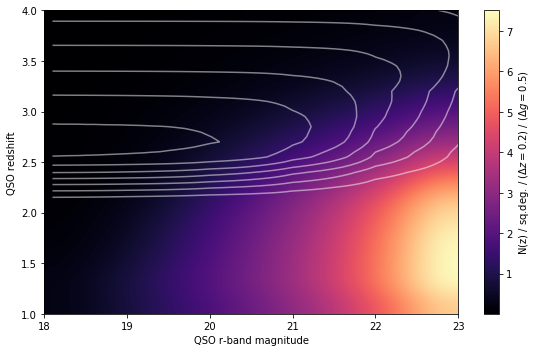

In [35]:
lumi_plot(rbin,zbin,nqso)
savefig('qlf.png')

We define the priors for the QSO (luminosity function)

In [37]:
def prior_qso(z_min,z_max,mag_r_min,mag_r_max):
    magbin, zbin, nqso = luminosity_function(tabrROSS4)
    z_min_cut = np.argmin(np.fabs(zbin-z_min))
    z_max_cut = np.argmin(np.fabs(zbin-z_max))
    mag_min_cut = np.argmin(np.fabs(mag_r_min-magbin))
    mag_max_cut = np.argmin(np.fabs(mag_r_max-magbin))
    if mag_max_cut==mag_min_cut:
        mag_max_cut=mag_min_cut+1
    if z_min==0:
        z_min_cut=0
    dz = zbin[1]-zbin[0]
    #print z_min_cut, z_max_cut, mag_min_cut, mag_max_cut,nqso[mag_min_cut:mag_max_cut, z_min_cut:z_max_cut] 
    return np.sum(nqso[mag_min_cut:mag_max_cut, z_min_cut:z_max_cut]*dz)

In [38]:
def value_qso(z_min,z_max,mag_r_min,mag_r_max):
    z_min_cut = np.argmin(np.fabs(z_vec-z_min))
    z_max_cut = np.argmin(np.fabs(z_vec-z_max))
    mag_min_cut = np.argmin(np.fabs(mag_r_min-r_vec))
    mag_max_cut = np.argmin(np.fabs(mag_r_max-r_vec))
    dz = z_vec[1]-z_vec[0]
    if mag_max_cut==mag_min_cut:
        mag_max_cut=mag_min_cut+1
    return np.sum(W[mag_min_cut:mag_max_cut,z_min_cut:z_max_cut]*dz)

In [39]:
%time prior_qso(2.1,2.6,22,22)

CPU times: user 286 µs, sys: 52 µs, total: 338 µs
Wall time: 299 µs


1.51814

In [40]:
import healpy as hp

We use the stellar and galaxy densities as priors to be galaxy or star

In [41]:
star_map = hp.read_map('./fake_qso/star_map_64.fits')
gal_map = hp.read_map('./fake_qso/galaxy_map_64.fits')   

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [42]:
def stellar_density(RA,DEC,star_map):
    pix_nums = hp.ang2pix(hp.get_nside(star_map),np.pi/2-DEC*np.pi/180.,np.pi*RA/180.)
    pix_area = hp.nside2pixarea(hp.get_nside(star_map),degrees=True)
    star_dens = star_map[pix_nums]/pix_area
    return star_dens

In [43]:
def gal_density(RA,DEC,gal_map):
    pix_nums = hp.ang2pix(hp.get_nside(gal_map),np.pi/2-DEC*np.pi/180.,np.pi*RA/180.)
    pix_area = hp.nside2pixarea(hp.get_nside(gal_map),degrees=True)
    gal_dens = gal_map[pix_nums]/pix_area
    return gal_dens

In [44]:
ratest = 10*np.random.random(len(prob_table))
dectest = 10*np.random.random(len(prob_table))
test_star = stellar_density(ratest,dectest,star_map)

In [46]:
print prob_table['Prob'][:,2]/np.sum(prob_table['Prob'],axis=1)

    Prob   
-----------
1.00535e-05
4.06234e-30
    0.99899
1.35427e-15
2.19541e-12
7.02888e-17
5.17974e-11
2.60384e-19
9.88459e-09
1.77034e-29
        ...
2.51984e-13
 1.9638e-09
7.72715e-19
8.03162e-14
 1.1454e-25
5.98745e-24
1.09467e-13
3.86715e-16
8.61536e-09
  0.0306874
7.52773e-08
Length = 3000 rows


# Reobservation value

In [47]:
def reobserve(ID,RA,DEC,magr,class_table,zbins=[2.1,2.6,3.1,4.0]):
    pstar = stellar_density(RA,DEC,star_map)*class_table['Prob'][ID,5]/np.sum(class_table['Prob'][ID,:],axis=1)
    pgal = gal_density(RA,DEC,gal_map)*(class_table['Prob'][ID,0])/np.sum(class_table['Prob'][ID,:],axis=1)
    pqso = np.zeros((len(ID),len(zbins)))
    vqso = np.zeros((len(ID),len(zbins)))
    for i in range(0,len(zbins)-1):
        pqso[:,i]=class_table['Prob'][ID,i+1]/np.sum(class_table['Prob'][ID,:],axis=1)*prior_qso(zbins[i],zbins[i+1],magr,magr)
        vqso[:,i]=value_qso(zbins[i],zbins[i+1],magr,magr)
    pqso[:,3]=prior_qso(0,zbins[0],magr,magr)*class_table['Prob'][ID,4]/np.sum(class_table['Prob'][ID,:],axis=1)
    value = 0
    for i in range(0,len(zbins)-1):
        value = value+pqso[:,i]*vqso[:,i]/(np.sum(pqso,axis=1)+pgal+pstar)
    return value

In [48]:
def true_reobserve(truth_table,zbins=[2.1,2.6,3.1,4.0],magr=22):
    values=np.zeros(len(truth_table))
    magrbin=np.argmin(np.fabs(magr-r_vec))
    qsos1 = truth_table['TRUE_OBJTYPE']=='HZ_QSO_1'
    qsos2 = truth_table['TRUE_OBJTYPE']=='HZ_QSO_2'
    qsos3 = truth_table['TRUE_OBJTYPE']=='HZ_QSO_3'
    values[qsos1]=value_qso(zbins[0],zbins[1],magr,magr)
    values[qsos2]=value_qso(zbins[1],zbins[2],magr,magr)
    values[qsos3]=value_qso(zbins[2],zbins[3],magr,magr)
    return values

In [49]:
reob_values = reobserve(np.arange(len(prob_table)),ratest,dectest,22,prob_table)

In [50]:
reob_truth = true_reobserve(truth_table)

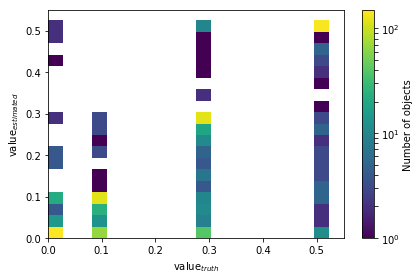

In [52]:
plt.hist2d(reob_truth,reob_values,cmap='viridis',vmin=1, vmax=150, range=[(0.,0.55),(0,0.55)],bins=20,
                norm=LogNorm() )
plt.colorbar(label='Number of objects')
plt.xlabel('value$_{truth}$')
plt.ylabel('value$_{estimated}$')
savefig('/Users/javiers/fake_qso/value_hist2d.png')

In [53]:
bad_qso = np.logical_and(reob_values>0.5,reob_truth<0.01)
hv_qso = reob_truth>0.5
print np.count_nonzero(bad_qso), np.count_nonzero(hv_qso)

2 202


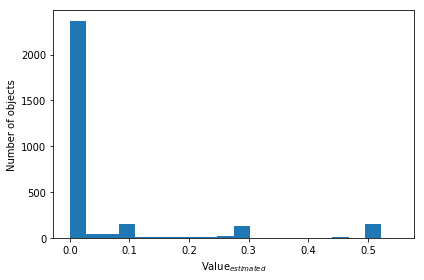

In [54]:
plt.hist(reob_values,bins=20,range=(0,0.55))
plt.xlabel('Value$_{estimated}$')
plt.ylabel('Number of objects')
savefig('value_hist.png')

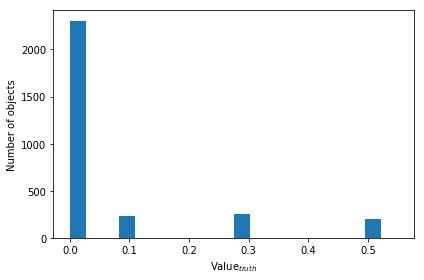

In [55]:
plt.hist(reob_truth,bins=20,range=(0,0.55))
plt.xlabel('Value$_{truth}$')
plt.ylabel('Number of objects')
savefig('value_hist_truth.png')

(array([ 2374.,    42.,   180.,    15.,    13.,    14.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ]),
 <a list of 6 Patch objects>)

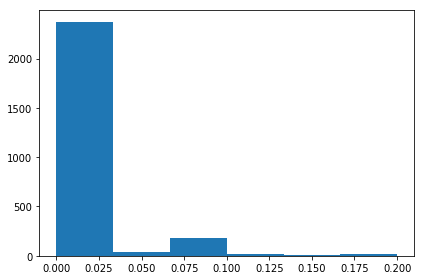

In [57]:
plt.hist(reob_values, bins=6, range=(0,0.2))

We use the densities of 3 patches from quicksurvey and will assign a random spectrum to each object according to their true class. 

In [58]:
tgt1 = astropy.table.Table.read('./fake_qso/qso_targets_RA0_DEC0.fits.gz') #Low
tgt2 = astropy.table.Table.read('./fake_qso/qso_targets_RA120_DEC1.fits.gz') #High
tgt3 = astropy.table.Table.read('./fake_qso/qso_targets_RA135_DEC45.fits.gz') #Medium stellar density

Best targets is the function that prioritizes the re-observations. It computes the value and then orders the targets according to it.

In [96]:
def best_targets(tgtlist):
    qso_tgt = np.logical_and(tgtlist['TRUETYPE']=='QSO',tgtlist['SOURCETYPE']=='QSO')
    star_tgt = np.logical_and(tgtlist['TRUETYPE']=='STAR',tgtlist['SOURCETYPE']=='QSO')
    qso_ids = np.zeros(np.count_nonzero(qso_tgt), dtype=int)
    star_ids = np.random.choice(np.where(truth_table['TRUE_OBJTYPE']=='STAR')[0],size=np.count_nonzero(star_tgt))
    qso_tgt2 = np.logical_or(truth_table['TRUE_OBJTYPE']=='GALAXY',truth_table['TRUE_OBJTYPE']=='STAR')
    print 'QSO number: ',len(qso_ids)
    print 'STAR number: ',len(star_ids)
    indices_array = np.where(~qso_tgt2)[0]
    for i in range(0,len(qso_ids)):
        qso_ids[i]=indices_array[np.argmin(np.fabs(tgtlist['TRUEZ'][qso_tgt][i]-truth_table['Z'][~qso_tgt2]))]
    reobserve_tgt_qso = reobserve(qso_ids,tgtlist['RA'][qso_tgt],tgtlist['DEC'][qso_tgt],22.,prob_table)
    reobserve_tgt_star = reobserve(star_ids,tgtlist['RA'][star_tgt],tgtlist['DEC'][star_tgt],22.,prob_table)
    reobserve_tgt = np.append(reobserve_tgt_qso,reobserve_tgt_star)
    best_tgt = np.argsort(reobserve_tgt)
    ids_array = np.append(qso_ids,star_ids)
    best_ids = ids_array[best_tgt[::-1]]
    eff = np.zeros(len(best_tgt)-1)
    purity = np.zeros(len(best_tgt)-1)
    for i in range(1,len(best_tgt)):
        stars=np.count_nonzero(best_tgt[0:i]>=len(qso_ids))
        qsos = i-stars
        eff[i-1]=1.0*qsos/(1.0*len(qso_ids))
        purity[i-1]=qsos/(1.0*i)
    return eff, purity, best_ids
    #print best_tgt[::-1]
    #print reobserve_tgt[best_tgt[::-1]]

In [166]:
eff1, pur1, best1 = best_targets(tgt1)

QSO number:  392
STAR number:  72


In [167]:
eff2, pur2, best2 = best_targets(tgt2)

QSO number:  808
STAR number:  567


In [168]:
eff3, pur3, best3 = best_targets(tgt3)

QSO number:  545
STAR number:  81


We plot efficiency and purity for each of the scenarios

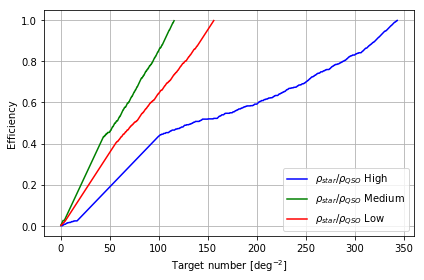

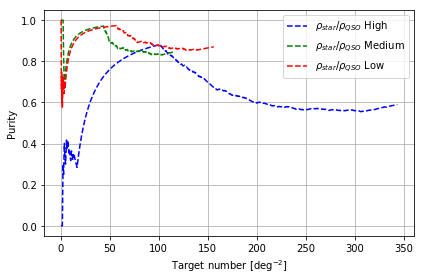

In [169]:
plt.figure()
plt.plot(np.arange(1,len(eff2)+1)/4.,eff2,'b-',label=r'$\rho_{star}/\rho_{QSO}$ High')
plt.plot(np.arange(1,len(eff1)+1)/4.,eff1,'g-',label=r'$\rho_{star}/\rho_{QSO}$ Medium')
plt.plot(np.arange(1,len(eff3)+1)/4.,eff3,'r-',label=r'$\rho_{star}/\rho_{QSO}$ Low')
plt.ylim(-0.05,1.05)
#plt.xlim(1,51)
plt.xlabel('Target number [deg$^{-2}$]')
plt.ylabel('Efficiency')
plt.legend(loc='best')
plt.grid()
savefig('efficiency_number.png')
plt.figure()
plt.plot(np.arange(1,len(eff2)+1)/4.,pur2,'b--',label=r'$\rho_{star}/\rho_{QSO}$ High')
plt.plot(np.arange(1,len(eff1)+1)/4.,pur1,'g--',label=r'$\rho_{star}/\rho_{QSO}$ Medium')
plt.plot(np.arange(1,len(eff3)+1)/4.,pur3,'r--',label=r'$\rho_{star}/\rho_{QSO}$ Low')
plt.ylim(-0.05,1.05)
plt.xlabel('Target number [deg$^{-2}$]')
plt.ylabel('Purity')
plt.legend(loc='best')
#plt.xlim(1,51)
plt.grid()
savefig('/Users/javiers/fake_qso/purity_number.png')
#plt.xscale('log')

[array([  3.81924410e-17,   9.33585884e-17,   3.49509264e-07,
         9.87807572e-01,   1.52895612e-19,   2.43593178e-07], dtype=float32), array([  4.79913251e-16,   4.23156340e-19,   3.93504500e-08,
         8.18188012e-01,   2.20075522e-20,   4.62770629e-07], dtype=float32), array([  1.25552504e-16,   5.67427097e-24,   6.29718847e-11,
         4.81956750e-02,   8.57050042e-24,   3.07341196e-07], dtype=float32), array([  1.65934030e-15,   2.55264091e-18,   1.16311947e-08,
         5.72809160e-01,   1.37016058e-19,   6.68515713e-06], dtype=float32), array([  1.42154287e-13,   1.54002353e-10,   5.02707480e-05,
         2.81261504e-02,   5.15614264e-14,   1.12414427e-05], dtype=float32), array([  1.35460684e-10,   2.56505417e-09,   1.75955929e-02,
         3.73098731e-12,   1.53995163e-08,   4.67724384e-08], dtype=float32), array([  1.35460684e-10,   2.56505417e-09,   1.75955929e-02,
         3.73098731e-12,   1.53995163e-08,   4.67724384e-08], dtype=float32), array([  2.39999887e-13,  

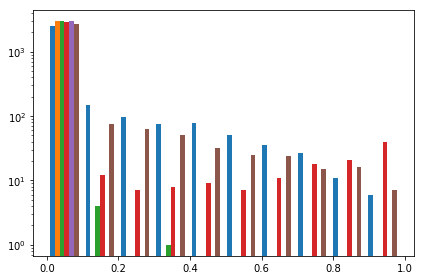

In [64]:
#Some values to chek that everything makes sense
print [prob_table[best1]['Prob'][i] for i in range(0,10)]
print truth_table['TRUE_OBJTYPE'][best1]
plt.hist(prob_table['Prob'])
plt.yscale('log')

Some checks of redmonster's results

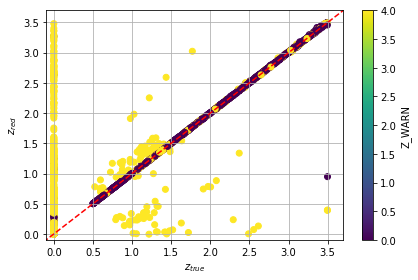

In [68]:
plt.scatter(truth_table['Z'],tab_nico['Z'],marker='o',c=tab_nico['ZWARN'],cmap='viridis')
plt.plot(np.arange(-1,5,0.5),np.arange(-1,5,0.5),'r--')
plt.xlim(-0.1,3.7)
plt.ylim(-0.1,3.7)
plt.colorbar(label='Z_WARN')
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$z_{red}$')
plt.grid()
savefig('./fake_qso/rm_nicolas_ztrue_zred.png')

In [69]:
np.count_nonzero(tab_nico['ZWARN']==0)/(1.0*len(tab_nico))

0.43733333333333335

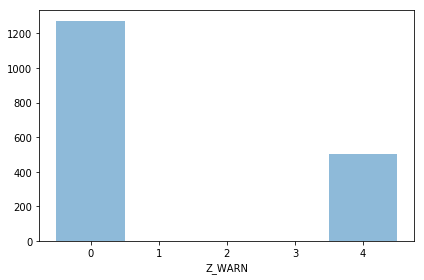

In [70]:
plt.hist(tab_nico['ZWARN'][tab_nico['SPECTYPE']=='QSO'],range=(-0.5,4.5),bins=5,alpha=0.5)
plt.xlabel('Z_WARN')
savefig('./fake_qso/rm_0.0.3_nicolas_zwarn_hist_qso.png')

In [71]:
print np.count_nonzero((truth_table['Z']-tab_nico['Z'])**2<tab_nico['ZERR']**2)/3000.
print np.count_nonzero((truth_table['Z'][tab_nico['SPECTYPE']=='QSO']-tab_nico['Z'][tab_nico['SPECTYPE']=='QSO'])**2<tab_nico['ZERR'][tab_nico['SPECTYPE']=='QSO']**2)/(1.*np.count_nonzero(truth_table['Z']>0))

0.139333333333
0.255876427132


In [72]:
print 'Number of QSOs', np.count_nonzero(truth_table['Z']>0)
print 'Number of correctly detected QSOs', np.count_nonzero(np.logical_and(tab_nico['SPECTYPE']=='QSO',truth_table['Z']>0))
print 'efficiency = ',np.count_nonzero(np.logical_and(tab_nico['SPECTYPE']=='QSO',truth_table['Z']>0))/(1.0*np.count_nonzero(truth_table['Z']>0))
print 'purity = ', 1./(np.count_nonzero(tab_nico['SPECTYPE']=='QSO')/(1.0*np.count_nonzero(truth_table['Z']>0)))

Number of QSOs 1489
Number of correctly detected QSOs 1375
efficiency =  0.923438549362
purity =  0.840293453725


In [73]:
qsob1 = np.logical_and(tab_nico['Z']>=2.1,tab_nico['Z']<2.6)
qso1_t=np.logical_and(qsob1,truth_table['TRUE_OBJTYPE']=='HZ_QSO_1')
qsob2 = np.logical_and(tab_nico['Z']>=2.6,tab_nico['Z']<3.1)
qso2_t=np.logical_and(qsob2,truth_table['TRUE_OBJTYPE']=='HZ_QSO_2')
qso3_t = np.logical_and(tab_nico['Z']>=3.1,truth_table['TRUE_OBJTYPE']=='HZ_QSO_3')
print 1.0*np.count_nonzero(qso3_t)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_3')
print 1.0*np.count_nonzero(qso2_t)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_2')
print 1.0*np.count_nonzero(qso1_t)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_1')

0.965346534653
0.972972972973
0.978723404255


In [74]:
print 1.0/(1.0*np.count_nonzero(tab_nico['Z']>=3.1)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_3'))
print 1.0/(1.0*np.count_nonzero(qsob2)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_2'))
print 1.0/(1.0*np.count_nonzero(qsob1)/np.count_nonzero(truth_table['TRUE_OBJTYPE']=='HZ_QSO_1'))

0.935185185185
0.851973684211
0.88679245283


In [81]:
def nico_reobserve(in_tab,zbins=[2.1,2.6,3.1,4.0],magr=22):
    values=np.zeros(len(in_tab))
    magrbin=np.argmin(np.fabs(magr-r_vec))
    zbin1 = np.logical_and(in_tab['Z']>=2.1,in_tab['Z']<2.6)
    zbin2 = np.logical_and(in_tab['Z']>=2.6,in_tab['Z']<3.1)
    zbin3 = in_tab['Z']>=3.1
    qsos1 = np.logical_and(in_tab['SPECTYPE']=='QSO',zbin1)
    qsos2 = np.logical_and(in_tab['SPECTYPE']=='QSO',zbin2)
    qsos3 = np.logical_and(in_tab['SPECTYPE']=='QSO',zbin3)
    values[qsos1]=value_qso(zbins[0],zbins[1],magr,magr)
    values[qsos2]=value_qso(zbins[1],zbins[2],magr,magr)
    values[qsos3]=value_qso(zbins[2],zbins[3],magr,magr)
    return values

In [82]:
def best_targets_nico(tgtlist):
    qso_tgt = np.logical_and(tgtlist['TRUETYPE']=='QSO',tgtlist['SOURCETYPE']=='QSO')
    star_tgt = np.logical_and(tgtlist['TRUETYPE']=='STAR',tgtlist['SOURCETYPE']=='QSO')
    qso_ids = np.zeros(np.count_nonzero(qso_tgt), dtype=int)
    star_ids = np.random.choice(np.where(truth_table['TRUE_OBJTYPE']=='STAR')[0],size=np.count_nonzero(star_tgt))
    qso_tgt2 = np.logical_or(truth_table['TRUE_OBJTYPE']=='GALAXY',truth_table['TRUE_OBJTYPE']=='STAR')
    print 'QSO number: ',len(qso_ids)
    print 'STAR number: ',len(star_ids)
    indices_array = np.where(~qso_tgt2)[0]
    for i in range(0,len(qso_ids)):
        qso_ids[i]=indices_array[np.argmin(np.fabs(tgtlist['TRUEZ'][qso_tgt][i]-truth_table['Z'][~qso_tgt2]))]
    reobserve_tgt_qso = nico_reobserve(tab_nico[qso_ids])
    reobserve_tgt_star = nico_reobserve(tab_nico[star_ids])
    reobserve_tgt = np.append(reobserve_tgt_qso,reobserve_tgt_star)
    ids_array = np.append(qso_ids,star_ids)
    best_tgt = np.argsort(reobserve_tgt)
    best_ids = ids_array[best_tgt[::-1]]
    eff = np.zeros(len(best_tgt)-1)
    purity = np.zeros(len(best_tgt)-1)
    for i in range(1,len(best_tgt)):
        stars=np.count_nonzero(best_tgt[0:i]>=len(qso_ids))
        qsos = i-stars
        eff[i-1]=1.0*qsos/(1.0*len(qso_ids))
        purity[i-1]=qsos/(1.0*i)
    return eff, purity, best_ids
    #print best_tgt[::-1]
    #print reobserve_tgt[best_tgt[::-1]]



In [92]:
eff1n, pur1n, best1n = best_targets_nico(tgt1)
eff2n, pur2n, best2n = best_targets_nico(tgt2)
eff3n, pur3n, best3n = best_targets_nico(tgt3)

QSO number:  392
STAR number:  72
QSO number:  808
STAR number:  567
QSO number:  545
STAR number:  81


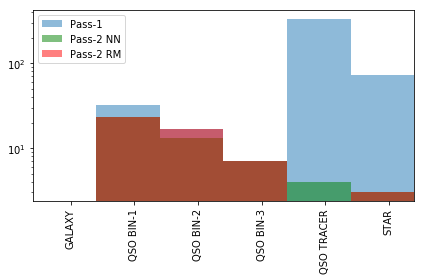

In [170]:
plt.hist(encoded_Y[best1n],label='Pass-1',alpha=0.5,range=(0,5),bins=6)
plt.hist(encoded_Y[best1[0:50]],label='Pass-2 NN',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='green')
plt.hist(encoded_Y[best1n[0:50]],label='Pass-2 RM',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='red')
ax = plt.gca()
plt.xticks(bins,labels,rotation='vertical')
ax.set_xticks(bins+0.5)
plt.xlim(0,5)
plt.legend(loc='best')
plt.yscale('log')
savefig('./fake_qso/1pass_class_medium.png')

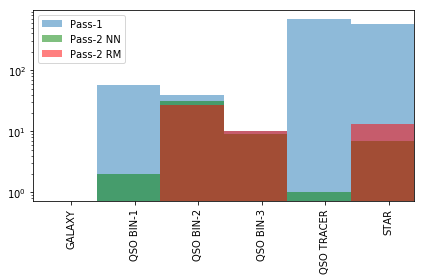

In [171]:
plt.hist(encoded_Y[best2],label='Pass-1',alpha=0.5,range=(0,5),bins=6)
plt.hist(encoded_Y[best2[0:50]],label='Pass-2 NN',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='green')
plt.hist(encoded_Y[best2n[0:50]],label='Pass-2 RM',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='red')
ax = plt.gca()
plt.xticks(bins,labels,rotation='vertical')
ax.set_xticks(bins+0.5)
plt.xlim(0,5)
plt.legend(loc='best')
plt.yscale('log')
savefig('./fake_qso/1pass_class_high.png')

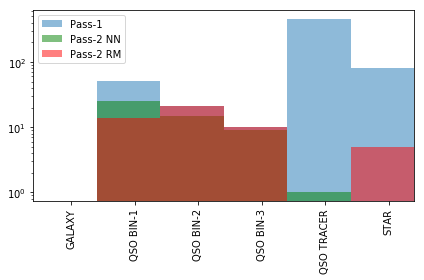

In [172]:
plt.hist(encoded_Y[best3],label='Pass-1',alpha=0.5,range=(0,5),bins=6)
plt.hist(encoded_Y[best3[0:50]],label='Pass-2 NN',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='green')
plt.hist(encoded_Y[best3n[0:50]],label='Pass-2 RM',alpha=0.5, range=(0,5),bins=6,linestyle='--',color='red')
ax = plt.gca()
plt.xticks(bins,labels,rotation='vertical')
ax.set_xticks(bins+0.5)
plt.xlim(0,5)
#plt.ylim(0,50)
plt.legend(loc='best')
plt.yscale('log')
savefig('./fake_qso/1pass_class_low.png')